In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report,
                           roc_curve, auc, roc_auc_score)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print(" Libraries imported successfully")
print("="*60)


 Libraries imported successfully


In [4]:
filename = "heart_disease.csv"

column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

df = pd.read_csv(filename, names=column_names)

print("\n Dataset Information:")
print("="*30)
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
print(f"\nFeature names:")
for i, col in enumerate(column_names, 1):
    print(f"{i:2}. {col}")

print("\n Data Sample:")
print(df.head())
print("\n Descriptive Statistics:")
print(df.describe())


 Dataset Information:
Number of samples: 303
Number of features: 14

Feature names:
 1. age
 2. sex
 3. cp
 4. trestbps
 5. chol
 6. fbs
 7. restecg
 8. thalach
 9. exang
10. oldpeak
11. slope
12. ca
13. thal
14. target

 Data Sample:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  target  
0    3.0  0.0  6.0       0  
1    2.0  3.0  3.0       2  
2    2.0  2.0  7.0       1  
3    3.0  0.0  3.0       0  
4    1.0  0.0  3.0       0  

 Descriptive Statistics:
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  3

In [7]:
print("\n Data Cleaning:")
print("="*60)

missing_values = df.isin(['?']).sum()
print("Missing values (?):")
print(missing_values[missing_values > 0])

df = df.replace('?', np.nan)
df = df.apply(pd.to_numeric, errors='coerce')

initial_rows = len(df)
df = df.dropna()
final_rows = len(df)
print(f"\nRows removed: {initial_rows - final_rows}")
print(f"Remaining rows: {final_rows}")

df['target_binary'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

print(f"\n Class Distribution:")
print(df['target_binary'].value_counts())
print(f"\nPercentage with disease: {(df['target_binary'].sum() / len(df) * 100):.1f}%")




 Data Cleaning:
Missing values (?):
Series([], dtype: int64)

Rows removed: 0
Remaining rows: 297

 Class Distribution:
target_binary
0    160
1    137
Name: count, dtype: int64

Percentage with disease: 46.1%



 Exploratory Data Analysis (EDA):


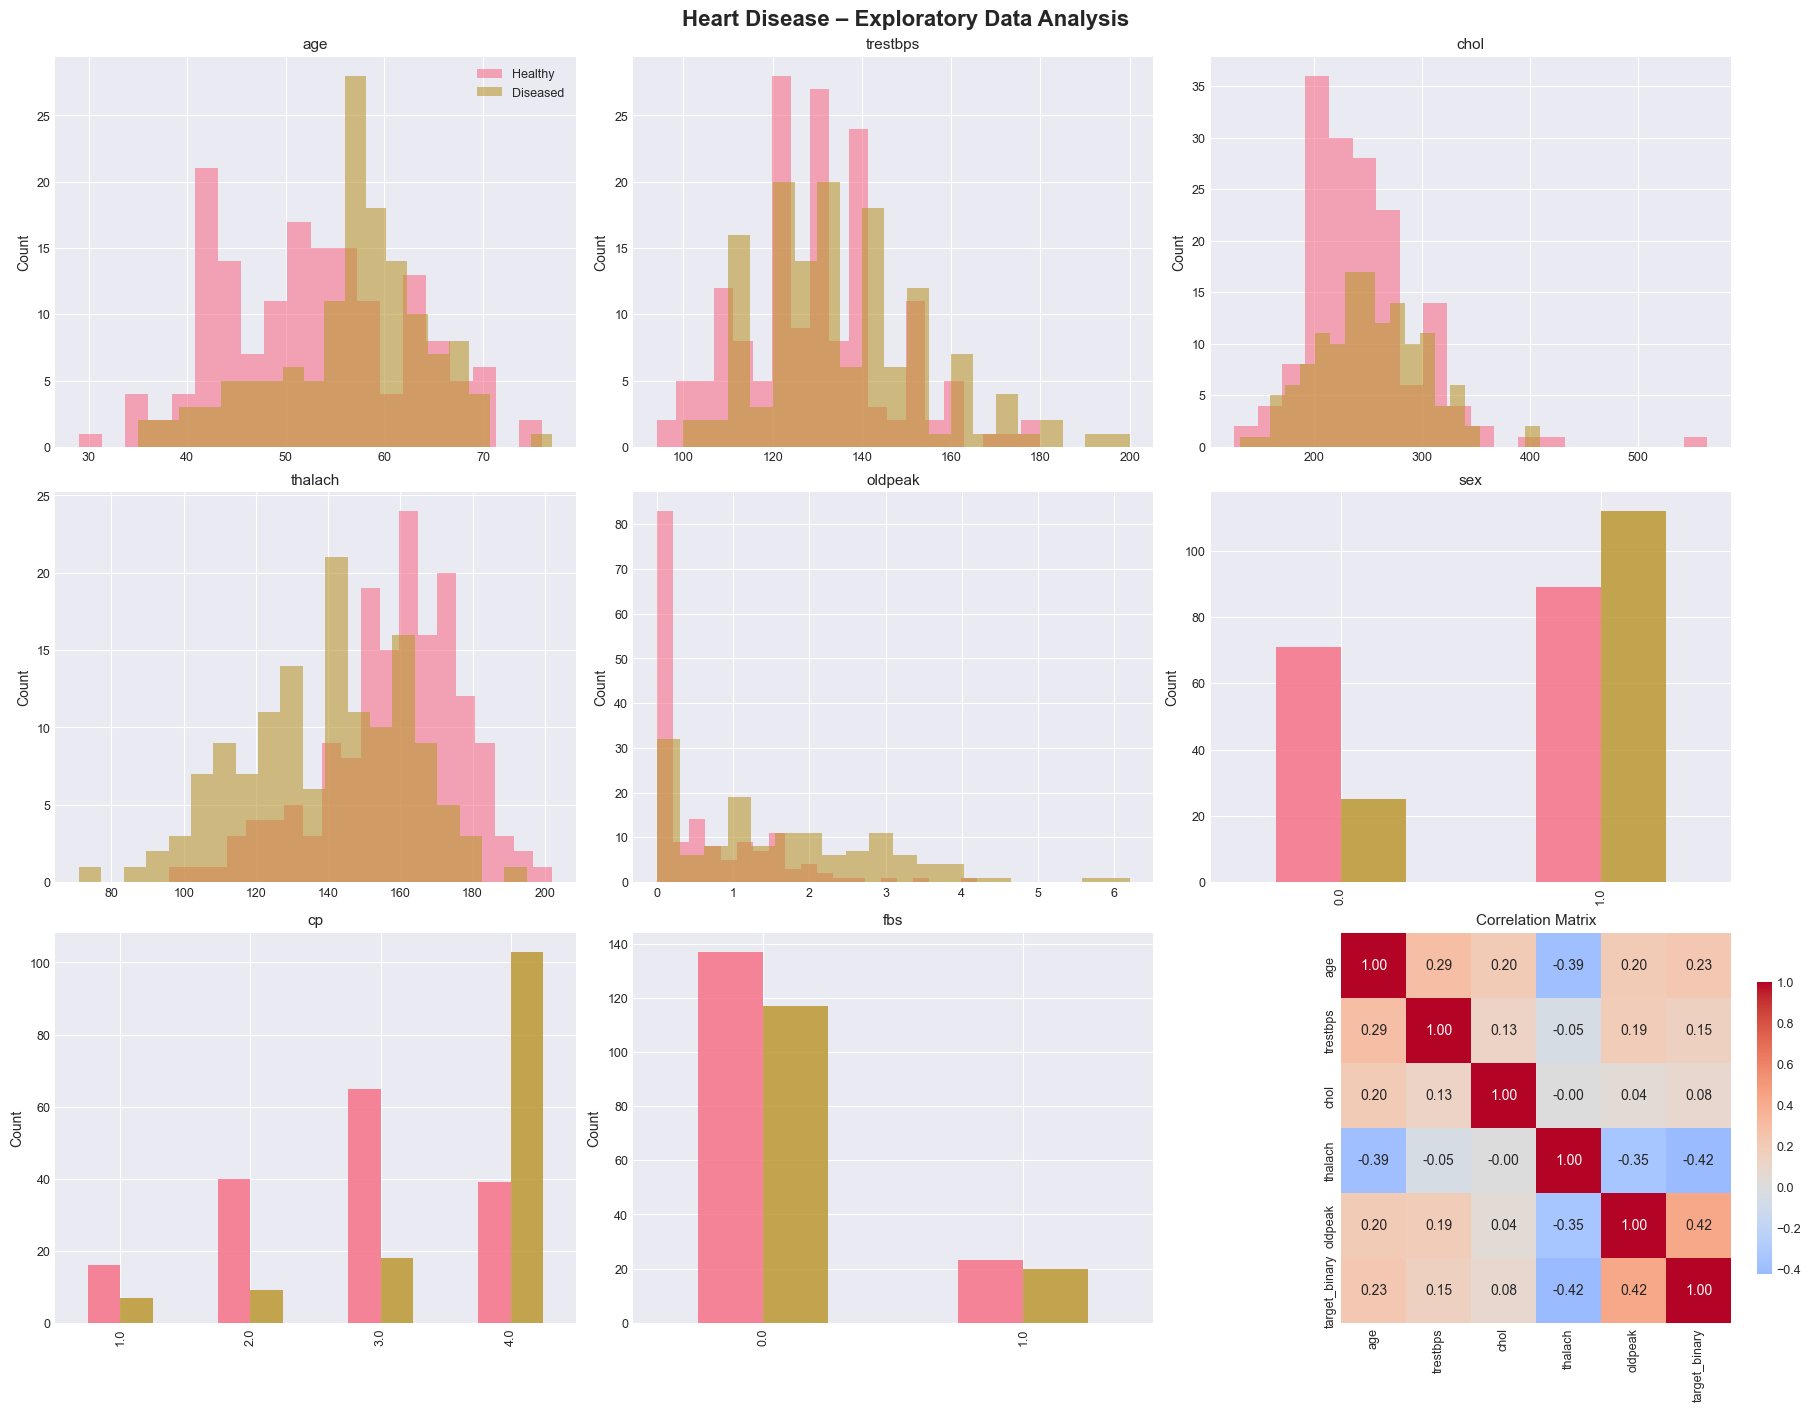

In [23]:
print("\n Exploratory Data Analysis (EDA):")
print("="*60)

def create_eda_plots(df):

    plt.rcParams.update({
        'axes.titlesize': 11,
        'axes.labelsize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9
    })

    fig, axes = plt.subplots(3, 3, figsize=(18, 14), constrained_layout=True)

    numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    
    # Numeric Histograms
    for i, feature in enumerate(numeric_features):
        ax = axes.flat[i]
        ax.hist(df[df['target_binary'] == 0][feature],
                bins=20, alpha=0.6, label='Healthy')
        ax.hist(df[df['target_binary'] == 1][feature],
                bins=20, alpha=0.6, label='Diseased')
        ax.set_title(f'{feature}')
        ax.set_ylabel('Count')
        if i == 0:
            ax.legend()

    # Categorical Features
    categorical_features = ['sex', 'cp', 'fbs', 'exang']
    for i, feature in enumerate(categorical_features, start=len(numeric_features)):
        ax = axes.flat[i]
        cross_tab = pd.crosstab(df[feature], df['target_binary'])
        cross_tab.plot(kind='bar', ax=ax, alpha=0.85, legend=False)
        ax.set_title(feature)
        ax.set_xlabel('')
        ax.set_ylabel('Count')

    # Correlation Heatmap
    ax = axes.flat[-1]
    corr = df[numeric_features + ['target_binary']].corr()
    sns.heatmap(
        corr,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0,
        square=True,
        cbar_kws={'shrink': 0.75},
        ax=ax
    )
    ax.set_title('Correlation Matrix')

    fig.suptitle(
        'Heart Disease – Exploratory Data Analysis',
        fontsize=16,
        fontweight='bold'
    )

    plt.show()

create_eda_plots(df)


In [25]:
print("\n Preparing Data for Modeling:")
print("="*32)

features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
            'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
X = df[features]
y = df['target_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data size: {X_train.shape[0]}")
print(f"Test data size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")
print(f"\nClass distribution in training: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Class distribution in test: {pd.Series(y_test).value_counts().to_dict()}")



 Preparing Data for Modeling:
Training data size: 237
Test data size: 60
Number of features: 13

Class distribution in training: {0: 128, 1: 109}
Class distribution in test: {0: 32, 1: 28}



 Decision Tree Implementation:

 Decision Tree Evaluation:
----------------------------------------
Accuracy: 0.8500
Precision: 0.8800
Recall: 0.7857
F1-Score: 0.8302

 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.83      0.91      0.87        32
    Diseased       0.88      0.79      0.83        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

 Confusion Matrix:


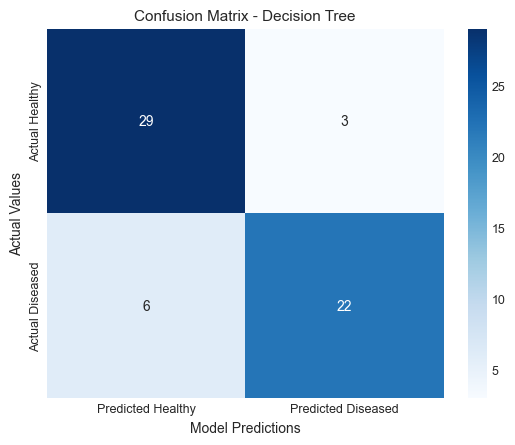

In [26]:
print("\n Decision Tree Implementation:")
print("="*60)

dt_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

print("\n Decision Tree Evaluation:")
print("-" * 40)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print(f"Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1-Score: {f1_dt:.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_dt, 
                           target_names=['Healthy', 'Diseased']))

print(" Confusion Matrix:")
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Healthy', 'Predicted Diseased'],
            yticklabels=['Actual Healthy', 'Actual Diseased'])
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('Actual Values')
plt.xlabel('Model Predictions')
plt.show()



 Random Forest Implementation:

 Random Forest Evaluation:
----------------------------------------
Accuracy: 0.8667
Precision: 0.8846
Recall: 0.8214
F1-Score: 0.8519

 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.85      0.91      0.88        32
    Diseased       0.88      0.82      0.85        28

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.87        60
weighted avg       0.87      0.87      0.87        60

 Confusion Matrix:


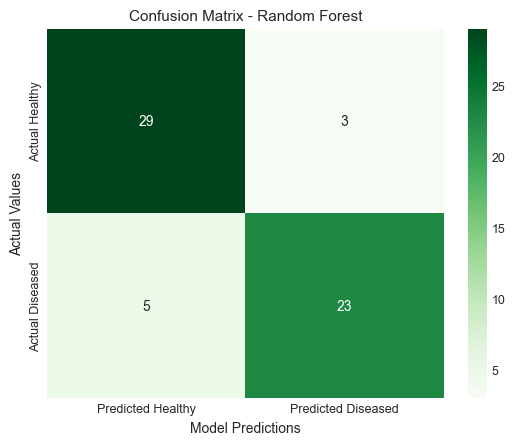

In [27]:
print("\n Random Forest Implementation:")
print("="*60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("\n Random Forest Evaluation:")
print("-" * 40)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_rf, 
                           target_names=['Healthy', 'Diseased']))

print(" Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Healthy', 'Predicted Diseased'],
            yticklabels=['Actual Healthy', 'Actual Diseased'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual Values')
plt.xlabel('Model Predictions')
plt.show()



 Model Comparison:
 Performance Comparison Table:
   Metric  Decision Tree  Random Forest
 Accuracy       0.850000       0.866667
Precision       0.880000       0.884615
   Recall       0.785714       0.821429
 F1-Score       0.830189       0.851852


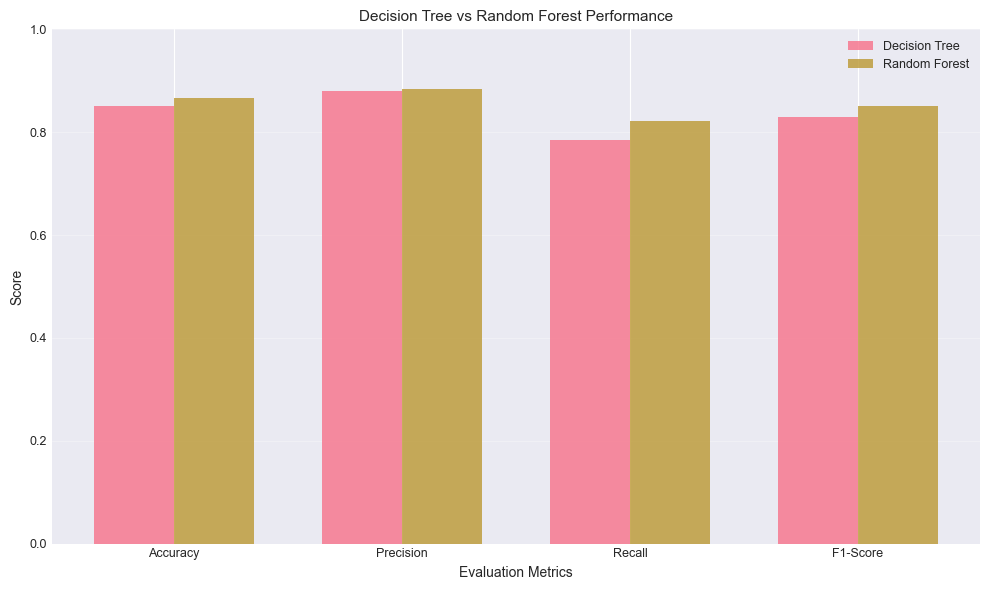

In [29]:
print("\n Model Comparison:")
print("="*34)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Decision Tree': [accuracy_dt, precision_dt, recall_dt, f1_dt],
    'Random Forest': [accuracy_rf, precision_rf, recall_rf, f1_rf]
})

print(" Performance Comparison Table:")
print(comparison_df.to_string(index=False))

plt.figure(figsize=(10, 6))
x = range(len(comparison_df))
width = 0.35

plt.bar([i - width/2 for i in x], comparison_df['Decision Tree'], 
        width, label='Decision Tree', alpha=0.8)
plt.bar([i + width/2 for i in x], comparison_df['Random Forest'], 
        width, label='Random Forest', alpha=0.8)

plt.xlabel('Evaluation Metrics')
plt.ylabel('Score')
plt.title('Decision Tree vs Random Forest Performance')
plt.xticks(x, comparison_df['Metric'])
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



 Feature Importance Analysis:
 Top 5 Important Features (Random Forest):
Feature  Importance
     cp    0.156692
   thal    0.138874
thalach    0.114321
oldpeak    0.112682
     ca    0.110378

 Top 5 Important Features (Decision Tree):
 Feature  Importance
    thal    0.396668
      cp    0.233834
      ca    0.087233
 oldpeak    0.084925
trestbps    0.083513


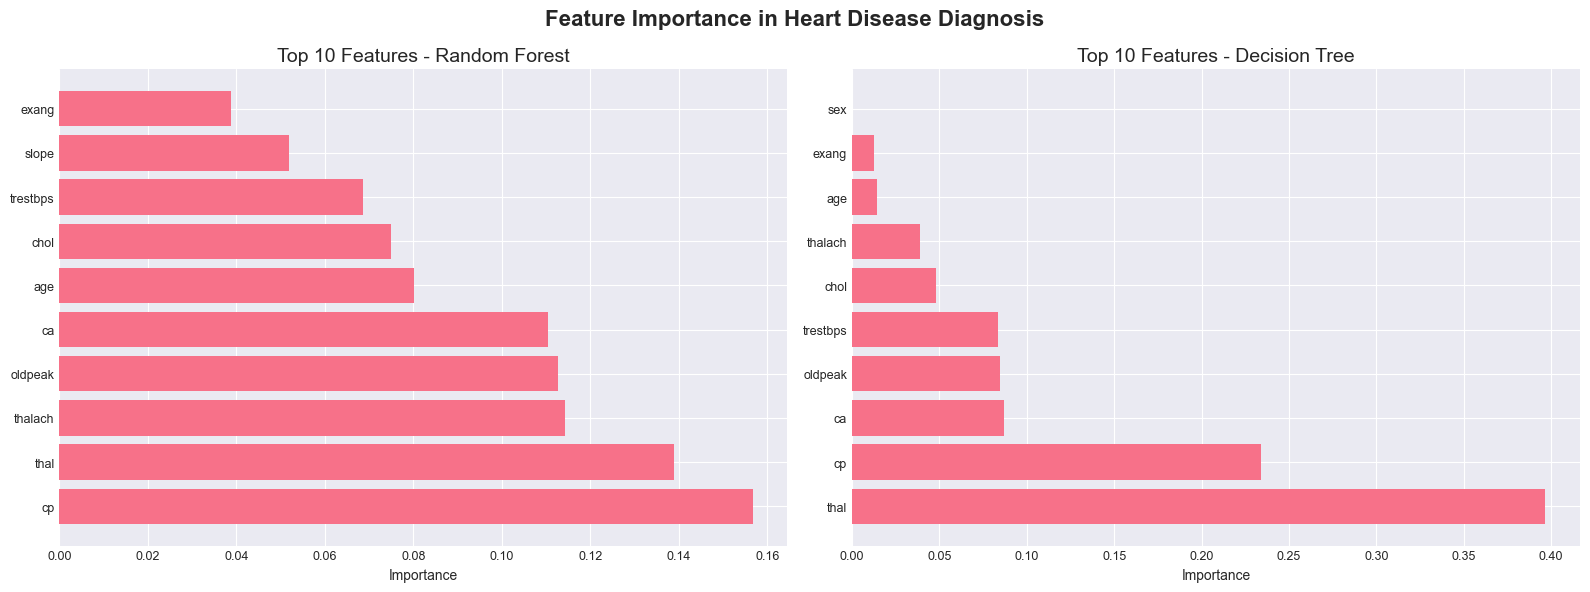

In [30]:
print("\n Feature Importance Analysis:")
print("="*60)

feature_importance_rf = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(" Top 5 Important Features (Random Forest):")
print(feature_importance_rf.head(5).to_string(index=False))

feature_importance_dt = pd.DataFrame({
    'Feature': features,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n Top 5 Important Features (Decision Tree):")
print(feature_importance_dt.head(5).to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(feature_importance_rf['Feature'][:10], 
            feature_importance_rf['Importance'][:10])
axes[0].set_title('Top 10 Features - Random Forest', fontsize=14)
axes[0].set_xlabel('Importance')

axes[1].barh(feature_importance_dt['Feature'][:10], 
            feature_importance_dt['Importance'][:10])
axes[1].set_title('Top 10 Features - Decision Tree', fontsize=14)
axes[1].set_xlabel('Importance')

plt.suptitle('Feature Importance in Heart Disease Diagnosis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


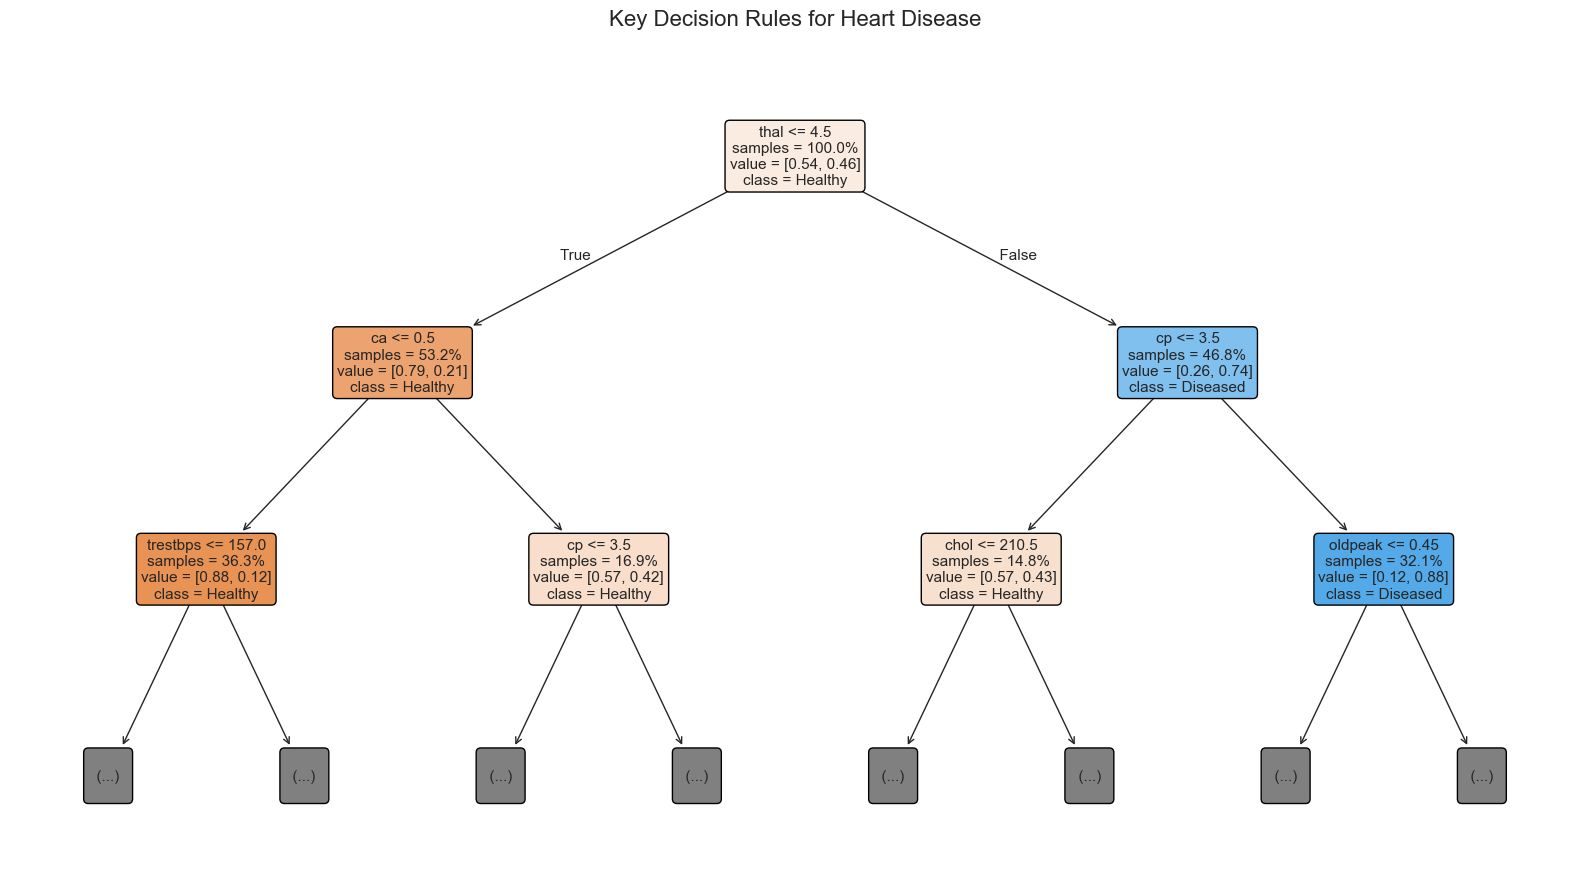

In [31]:
plt.figure(figsize=(16, 9))

plot_tree(
    dt_model,
    feature_names=features,
    class_names=['Healthy', 'Diseased'],
    filled=True,
    rounded=True,
    max_depth=2,
    fontsize=11,
    impurity=False,
    proportion=True,
    precision=2
)

plt.title(
    'Key Decision Rules for Heart Disease',
    fontsize=16,
    pad=20
)

plt.tight_layout()
plt.show()



 ROC Curve Analysis:


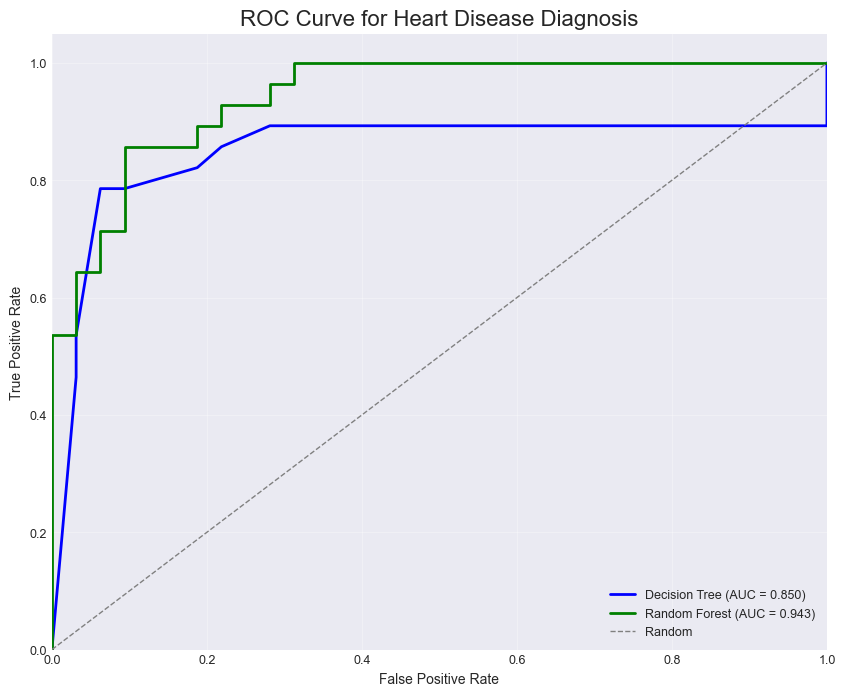

In [34]:
print("\n ROC Curve Analysis:")


fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2,
         label=f'Decision Tree (AUC = {roc_auc_dt:.3f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2,
         label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Heart Disease Diagnosis', fontsize=16)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
